In [1]:
import os
import sys
import re
import torch
import struct
import math

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from copy import deepcopy
from scipy.stats import skew
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN


/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
source_folder = "/home/g.esposito/sc2-benchmark"
relative_path = "resource/ckpt/pascal_voc2012/supervised_compression/ghnd-bq/"
weights_dir = os.path.join(source_folder, relative_path)
weights_files = os.listdir(weights_dir)
file_path = os.path.join(weights_dir, weights_files[1])
model = torch.load(file_path, map_location=torch.device('cpu'))
to_reduce = model['model']['backbone.bottleneck_layer.encoder.4.weight'].flatten()
# model['model'].keys()

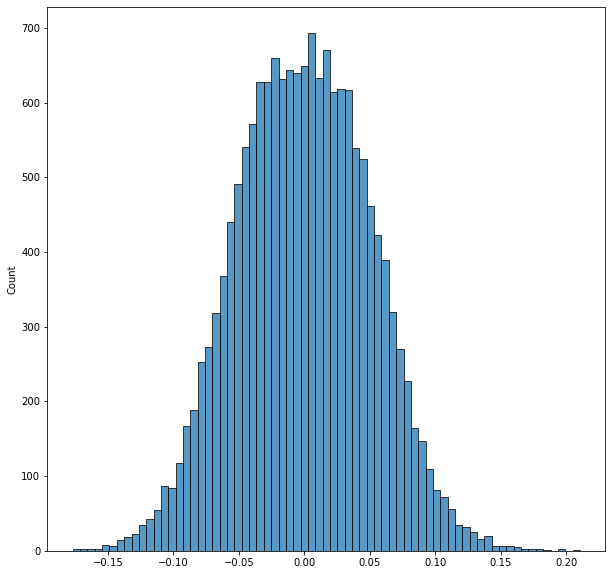

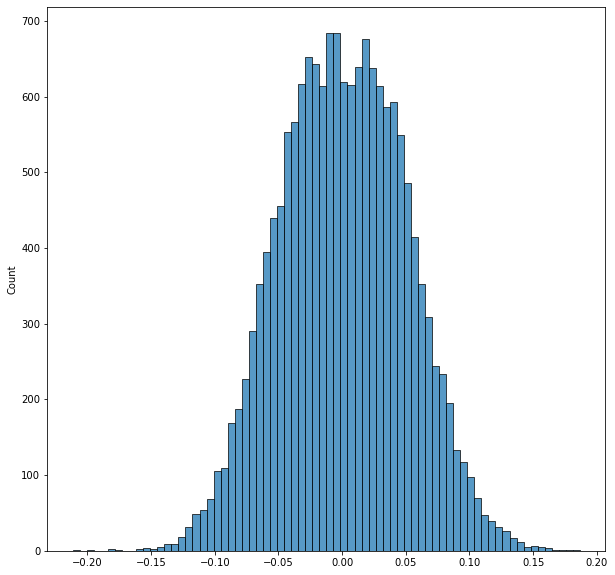

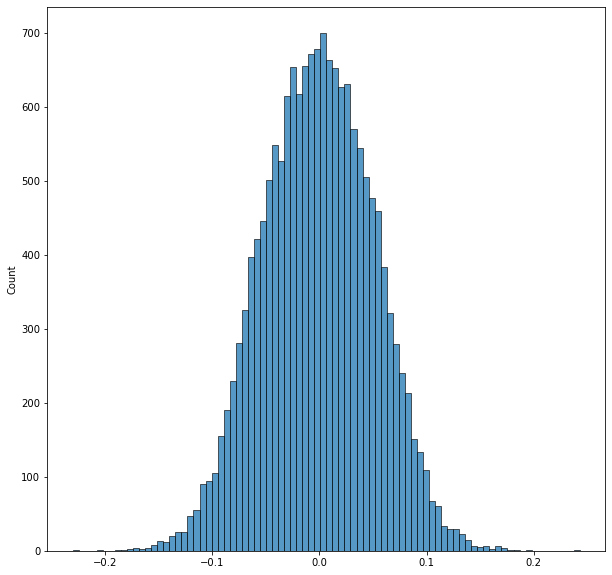

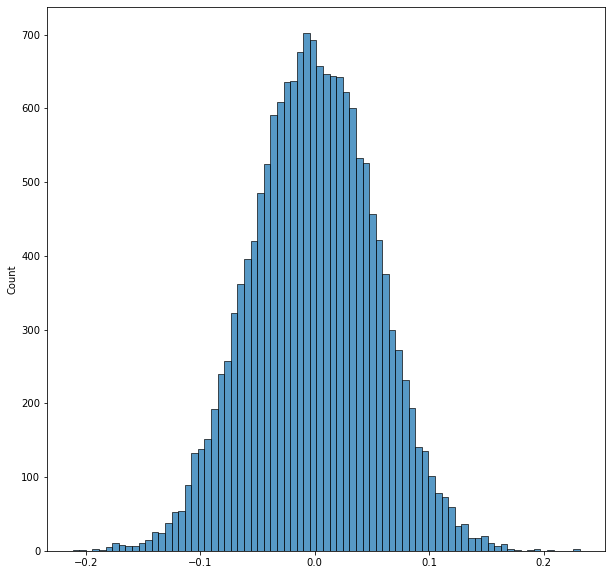

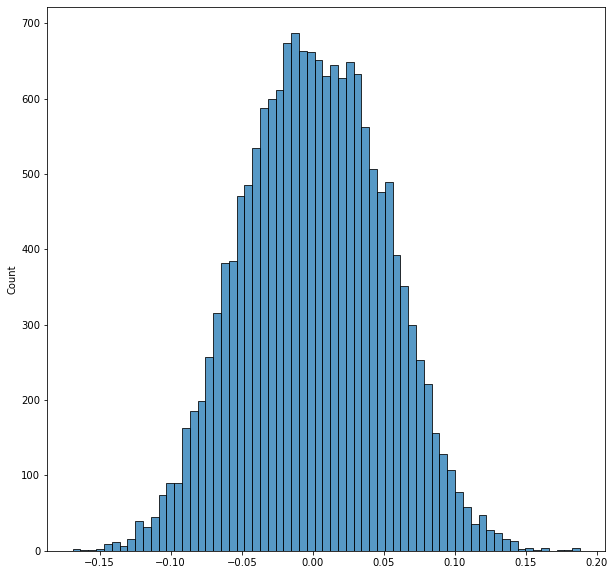

In [3]:

source_folder = "/home/g.esposito/sc2-benchmark"
relative_path = "resource/ckpt/pascal_voc2012/supervised_compression/ghnd-bq/"
weights_dir = os.path.join(source_folder, relative_path)
weights_files = os.listdir(weights_dir)
for i in range(len(weights_files[1:])):
    fig, ax = plt.subplots(1,1, figsize = (10, 10))
    file_path = os.path.join(weights_dir, weights_files[i])
    model = torch.load(file_path, map_location=torch.device('cpu'))
    to_plot = model['model']['backbone.bottleneck_layer.encoder.4.weight'].flatten()
    # print(model['optimizer']['state'][0].keys())
    # print(model['model']['backbone.bottleneck_layer.encoder.0.weight'].shape)
    sns.histplot(data = to_plot, ax = ax)

In [4]:
os.chdir("/home/g.esposito/sc2-benchmark")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/g.esposito/sc2-benchmark") if "L" in file_path and file_path != "LICENSE"]
# print(log_folders)

general_report = pd.DataFrame([])
for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store"]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "fsim_full_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                report.loc[idx, 'boxes_Crit'] = report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = report['boxes_Crit'] + report['boxes_SDC'] + report['boxes_Masked']
            # for val in tot_boxes_per_fault:
            #     if val == 0:
            #         print('queste sono tutte critiche')
            report['Crit_perc'] = (report['boxes_Crit'] / tot_boxes_per_fault)*100
            report['SDC_perc'] = (report['boxes_SDC'] / tot_boxes_per_fault)*100
            report['masked_perc'] = (report['boxes_Masked'] / tot_boxes_per_fault)*100
            general_report = pd.concat([general_report, report], axis=0, ignore_index=True)

general_report.dropna(inplace=True)
def int_to_float(h):
    return float(struct.unpack(">f",struct.pack(">I",h))[0])

general_report['free_weight']=general_report['Ffree_Weight'].astype(int).apply(int_to_float)
general_report['faul_weight']=general_report['Faulty_weight'].astype(int).apply(int_to_float)
general_report['faul_weight']

0      -3.928674e-21
1      -6.778787e-01
2       1.108305e-01
3      -1.725418e-01
4       1.348294e+00
            ...     
9366   -6.839111e-12
9367    3.495024e-21
9368    1.274561e-01
9369   -4.566996e-01
9370    4.333747e-01
Name: faul_weight, Length: 9157, dtype: float64

In [5]:
def check_for_infinity(series):
    infinite_indices = []
    for i, value in enumerate(series):
        if math.isnan(value):
            infinite_indices.append(i)
    return infinite_indices

0.2845260049907512
0.16768757009461666
2.781226979795884e+37
-1.7206910914464357


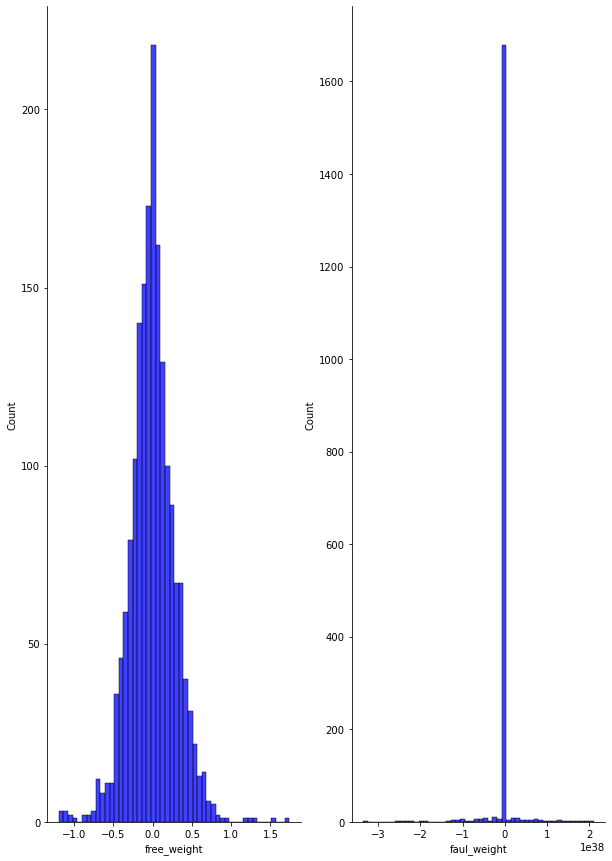

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
sns.despine(fig)
weights = general_report[['free_weight', 'faul_weight', 'layer', 'conf_detail']][general_report['layer']==4]
# weights['faul_weight'] = weights['faul_weight'].astype(int)
# print(check_for_infinity(weights['faul_weight']))
sns.histplot(weights['free_weight'], color='blue', ax=ax[0], bins=50)
sns.histplot(weights['faul_weight'], color='blue', ax=ax[1], bins=50)
# sns.histplot(data=weights, x = 'faul_weight', color='red', ax = ax)
# plt.tight_layout()
# ax.set_yscale('log')
print(np.std(weights['free_weight']))
print(skew(weights['free_weight']))

print(np.std(weights['faul_weight']))
print(skew(weights['faul_weight']))

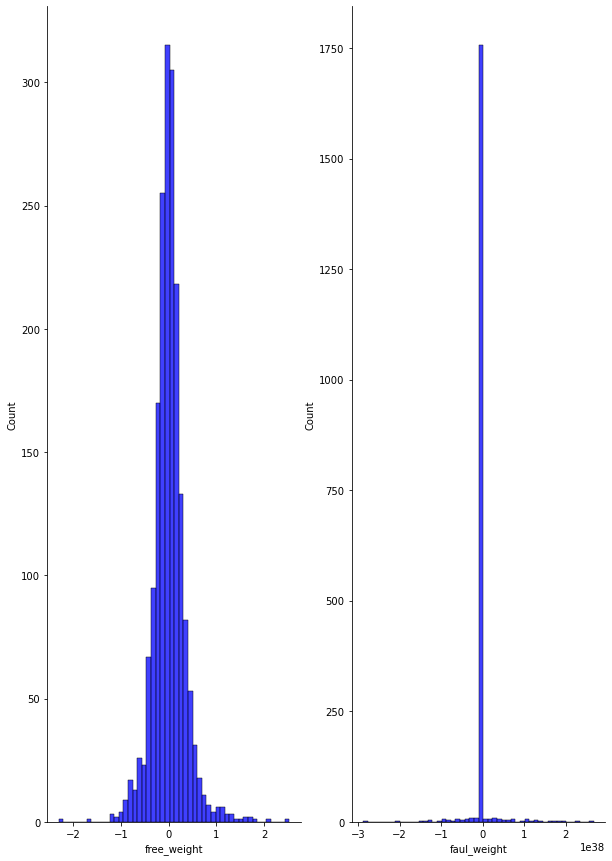

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
sns.despine(fig)
weights = general_report[['free_weight', 'faul_weight', 'layer', 'conf_detail']][general_report['layer']==3]
# weights['faul_weight'] = weights['faul_weight'].astype(int)
# print(check_for_infinity(weights['faul_weight']))
sns.histplot(weights['free_weight'], color='blue', ax=ax[0], bins=50)
sns.histplot(weights['faul_weight'], color='blue', ax=ax[1], bins=50)

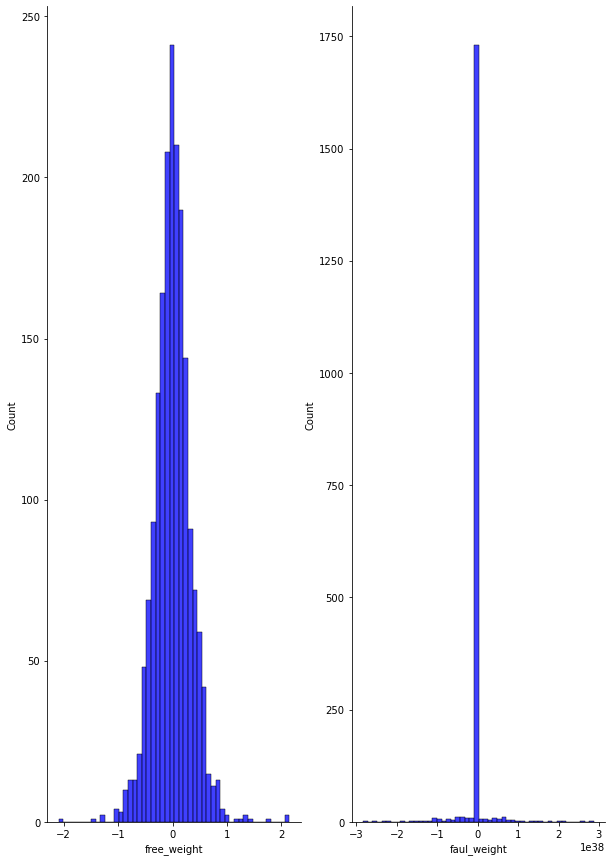

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
sns.despine(fig)
weights = general_report[['free_weight', 'faul_weight', 'layer', 'conf_detail']][general_report['layer']==2]
# weights['faul_weight'] = weights['faul_weight'].astype(int)
# print(check_for_infinity(weights['faul_weight']))
sns.histplot(weights['free_weight'], color='blue', ax=ax[0], bins=50)
sns.histplot(weights['faul_weight'], color='blue', ax=ax[1], bins=50)
# sns.histplot(data=weights, x = 'faul_weight', color='red', ax = ax)
# plt.tight_layout()
# ax.set_yscale('log')

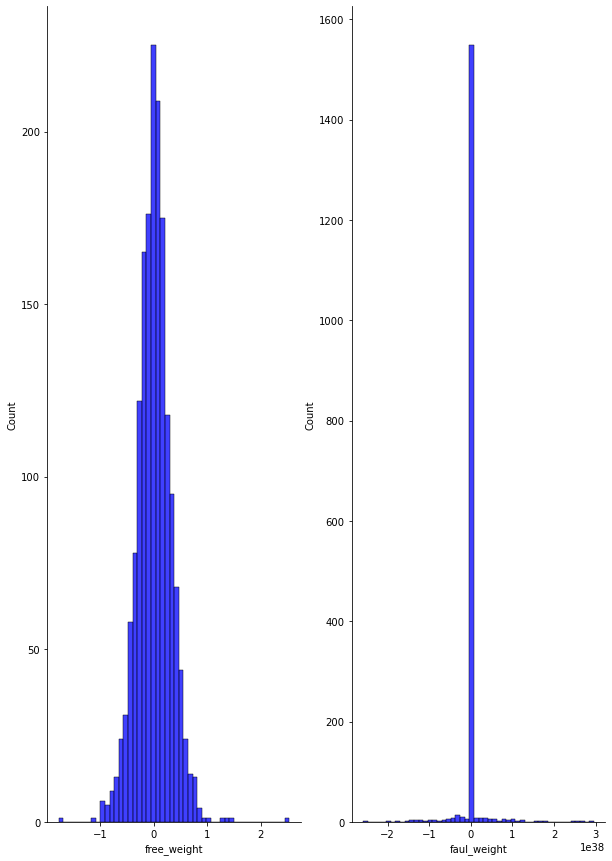

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
sns.despine(fig)
weights = general_report[['free_weight', 'faul_weight', 'layer', 'conf_detail']][general_report['layer']==1]
# weights['faul_weight'] = weights['faul_weight'].astype(int)
# print(check_for_infinity(weights['faul_weight']))
sns.histplot(weights['free_weight'], color='blue', ax=ax[0], bins=50)
sns.histplot(weights['faul_weight'], color='blue', ax=ax[1], bins=50)
# sns.histplot(data=weights, x = 'faul_weight', color='red', ax = ax)
# plt.tight_layout()
# ax.set_yscale('log')

In [10]:
general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc', 'free_weight', 'faul_weight'],
      dtype='object')

In [11]:
fault_detail = general_report[['kernel', 'channel', 'row', 'col', 'faul_weight', 'layer']][general_report['layer'] == 4][general_report['conf_detail'] == 'cnf1']
# prendi il

<ipython-input-11-c7805f679cd9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fault_detail = general_report[['kernel', 'channel', 'row', 'col', 'faul_weight', 'layer']][general_report['layer'] == 4][general_report['conf_detail'] == 'cnf1']


In [12]:
original_weights = torch.zeros((6,64, 64, 2, 2))



source_folder = "/home/g.esposito/sc2-benchmark"
relative_path = "resource/ckpt/pascal_voc2012/supervised_compression/ghnd-bq/"
weights_dir = os.path.join(source_folder, relative_path)
weights_files = os.listdir(weights_dir)
print(len(weights_files))
for extra_dim in range(original_weights.shape[0]):
    file_path = os.path.join(weights_dir, weights_files[extra_dim])
    model = torch.load(file_path, map_location=torch.device('cpu'))
    original_weights[extra_dim, :, :, :, :] = model['model']['backbone.bottleneck_layer.encoder.4.weight']

faulty_weights = deepcopy(original_weights)
# print(model['model']['backbone.bottleneck_layer.encoder.4.weight'].shape)
# to_reduce = model['model']['backbone.bottleneck_layer.encoder.4.weight'].flatten()
original_weights.shape

for idx, record in fault_detail.iterrows():
    kernel = int(record['kernel'])
    channel = int(record['channel'])
    row = int(record['row'])
    col = int(record['col'])
    faulty_weights[0,kernel, channel, row, col] = record['faul_weight']



6


In [16]:
# Reshape the tensor into a 2D array
num_features = faulty_weights.shape[0]
num_samples = np.prod(faulty_weights.shape[1:])
flattened_data = faulty_weights.reshape(num_samples, num_features)
# df = pd.DataFrame(flattened_data)
# flattened_data.shape
df = pd.DataFrame(flattened_data)
epsilon = 0.5
min_samples = 50
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(flattened_data)
labels = pd.DataFrame(db.labels_)
labels.value_counts()
# who are whese values? check kernel and so on..
# tune the DBSCAN

 0    16368
-1       16
dtype: int64

In [41]:

pca_1_m = PCA(n_components = 3, random_state = 42)
pca_1_m.fit(weights)
weights_red = pca_1_m.transform(weights)
# eps = np.sqrt(1 / pca_1.n_features_X
weights_red.shape

ValueError: could not convert string to float: 'cnf1'